In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import cv2 as cv
IMGPATH='./dataset/VOCdevkit_train/VOC2007/JPEGImages/'
currentImg = IMGPATH + '000005.jpg'
img = cv.imread(currentImg)


In [2]:
print(type(img))
print(img.shape)

<class 'numpy.ndarray'>
(375, 500, 3)


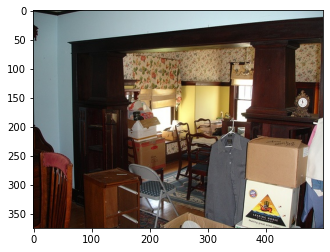

In [3]:
#Show the image with matplotlib
# plt.imshow(img)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

We want to crop the chair from the image
```
<object>
    <name>chair</name>
    <pose>Rear</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
        <xmin>263</xmin>
        <ymin>211</ymin>
        <xmax>324</xmax>
        <ymax>339</ymax>
    </bndbox>
</object>
```

In [4]:
import numpy as np
 
def add_alpha_channel(img):
    """ 为jpg图像添加alpha通道 """
 
    b_channel, g_channel, r_channel = cv.split(img) # 剥离jpg图像通道
    alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * 255 # 创建Alpha通道
 
    img_new = cv.merge((b_channel, g_channel, r_channel, alpha_channel)) # 融合通道
    return img_new

In [5]:
def merge_images_with_transparency(background, foreground_with_alpha, top, bottom, left, right):
    """將具有透明通道的前景 PNG 圖像合併到背景 JPG 圖像上
       top, bottom, left, right 為叠加位置坐标值
    """

    # 檢查背景圖像是否為 4 通道
    if background.shape[2] == 3:
        background = add_alpha_channel(background)
    
    '''
    當進行圖像合併時，由於位置可能設置不當，可能會導致前景 PNG 圖像的邊界超過背景 JPG 圖像，
    而導致程序報錯。這裡設定一系列叠加位置的限制，以便在前景 PNG 圖像超出背景 JPG 圖像範圍時仍能正常進行合併。
    '''
    top_limit, bottom_limit, left_limit, right_limit = 0, foreground_with_alpha.shape[0], 0, foreground_with_alpha.shape[1]
 
    if left < 0:
        left_limit = -left
        left = 0
    if top < 0:
        top_limit = -top
        top = 0
    if right > background.shape[1]:
        right_limit = foreground_with_alpha.shape[1] - (right - background.shape[1])
        right = background.shape[1]
    if bottom > background.shape[0]:
        bottom_limit = foreground_with_alpha.shape[0] - (bottom - background.shape[0])
        bottom = background.shape[0]
 
    # 獲取要覆蓋圖像的透明度值，將像素值除以 255，使值保持在 0-1 之間
    alpha_foreground = foreground_with_alpha[top_limit:bottom_limit, left_limit:right_limit, 3] / 255.0
    alpha_background = 1 - alpha_foreground
    
    image_copy = background.copy()


    # 開始合併
    for color_channel in range(0, 3):
        image_copy[top:bottom, left:right, color_channel] = (
            (alpha_background * background[top:bottom, left:right, color_channel]) +
            (alpha_foreground * foreground_with_alpha[top_limit:bottom_limit, left_limit:right_limit, color_channel])
        )
 
    return image_copy


### Create sticker 

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


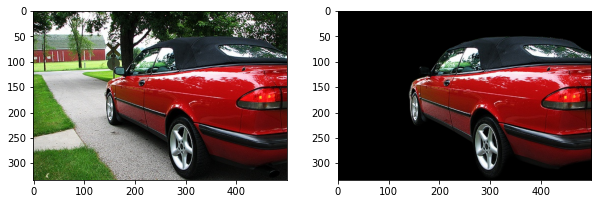

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [6]:
from rembg import remove
import cv2


def remove_background(input_path, output_path): # input could be jpg file, but output should be png file
    input = cv.imread(input_path)
    output = remove(input)
    cv2.imwrite(output_path, output)
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.imshow(cv.cvtColor(input, cv.COLOR_BGR2RGB))
    plt.subplot(1,2,2)
    plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
    plt.show()
    return output


input_path = './dataset/VOCdevkit_train/VOC2007/JPEGImages/000007.jpg'
output_path = './output_car.png'
remove_background(input_path, output_path)

We use [rembg](https://github.com/danielgatis/rembg) to remove background.

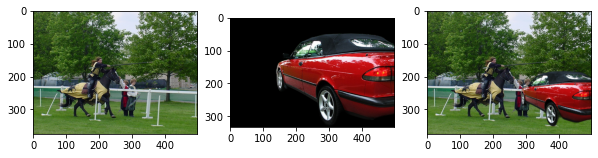

In [22]:
def resize_with_aspect_ratio(image, new_width):
    # 獲取原始圖片的高度、寬度和通道數
    height, width = image.shape[:2]
    
    # 計算新的高度，以保持原始寬高比
    aspect_ratio = width / height
    new_height = int(new_width / aspect_ratio)
    
    # 使用cv2.resize調整圖片大小
    resized_image = cv2.resize(image, (new_width, new_height))
    
    return resized_image


def _paste_image(background_path, sticker_path, new_img_path,new_width_sticker, x_pos, y_pos):
    background = cv.imread(background_path)
    sticker = cv.imread(sticker_path, cv.IMREAD_UNCHANGED)
    resized_sticker = resize_with_aspect_ratio(sticker, new_width_sticker)
    sticker_x_min = x_pos
    sticker_x_max = x_pos + resized_sticker.shape[0]
    sticker_y_min = y_pos
    sticker_y_max = y_pos + resized_sticker.shape[1]
    new_img = merge_images_with_transparency(background, resized_sticker, sticker_x_min, sticker_x_max, sticker_y_min, sticker_y_max)
    cv.imwrite(new_img_path, new_img)
    plt.figure(figsize=(10,6))
    plt.subplot(1,3,1)
    plt.imshow(cv.cvtColor(background, cv.COLOR_BGR2RGB))
    plt.subplot(1,3,2)
    plt.imshow(cv.cvtColor(sticker, cv.COLOR_BGR2RGB))
    plt.subplot(1,3,3)
    plt.imshow(cv.cvtColor(new_img, cv.COLOR_BGR2RGB))
    plt.show()
    return new_img, sticker_x_min, sticker_x_max, sticker_y_min, sticker_y_max
    # return new_img, x_min,


background_path = './dataset/VOCdevkit_train/VOC2007/JPEGImages/000009.jpg'
sticker_path = './output_car.png'
new_img_path = './new_img.jpg'
_ = _paste_image(background_path = background_path,sticker_path = sticker_path ,new_img_path = new_img_path , new_width_sticker=300, x_pos = 155, y_pos = 200)

In [8]:
def copy_and_paste(input_path, stick_path, output_path):
    _remove_background(stick_path)
    _copy_from_img()
    _paste_image()